> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Prediction and Evaluation

In [1]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
bundle_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.21/spacenet-vegas-buildings-ss/train/model-bundle.zip'

In [3]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2023-07-20 18:36:58:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.20/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2023-07-20 18:36:58:rastervision.pipeline.file_system.utils: INFO - Downloading s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.20/spacenet-vegas-buildings-ss/train/model-bundle.zip to /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/model-zoo-0.20/spacenet-vegas-buildings-ss/train/model-bundle.zip...


Downloading:  93%|#########2| 130M/140M [00:05<00:00, 27.3MB/s]

2023-07-20 18:37:05:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmp_rz_rtib/model-bundle
2023-07-20 18:37:06:rastervision.pytorch_learner.learner: INFO - Local output dir: /opt/data/tmp/tmp_rz_rtib/s3/raster-vision/examples/0.20.1/output/spacenet-vegas-buildings-ss/train
2023-07-20 18:37:06:rastervision.pytorch_learner.learner: INFO - Remote output dir: s3://raster-vision/examples/0.20.1/output/spacenet-vegas-buildings-ss/train
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 28.6MB/s]
2023-07-20 18:37:12:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmp_rz_rtib/model-bundle/model.pth


## Get scene to predict

In [4]:
scene_id = 5631
image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [5]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['building', 'background'], 
    colors=['orange', 'black'])
class_config.ensure_null_class()

In [6]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

import albumentations as A

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    size=325,
    stride=325,
    transform=A.Resize(325, 325))

2023-07-20 18:38:17:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.


In [7]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(325, 325)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config))

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

## Visualize predictions

In [8]:
scores = pred_labels.get_score_arr(pred_labels.extent)

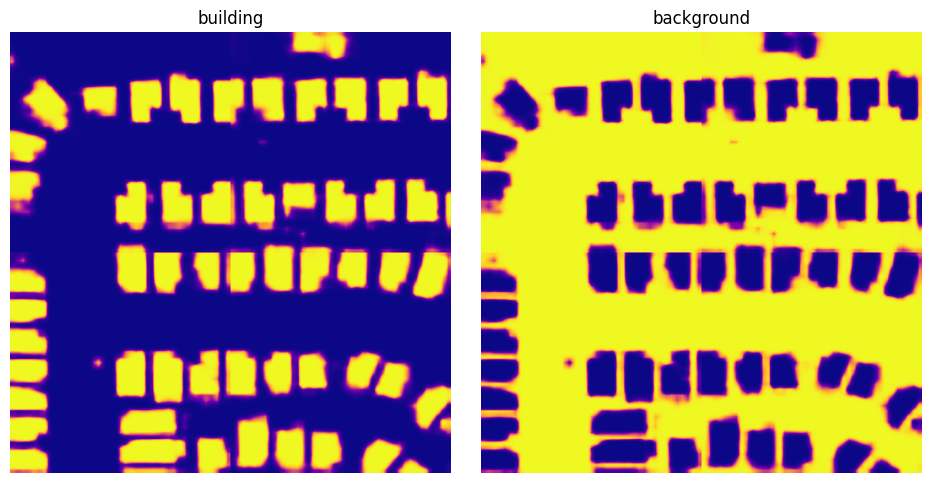

In [9]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [10]:
pred_labels.save(
    uri=f'./spacenet-vegas-buildings-ss/predict/{scene_id}',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate predictions

In [11]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

2023-07-20 18:44:48:rastervision.pipeline.file_system.utils: INFO - Downloading s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson to /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson...


In [12]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Evaluation for the building class:

In [13]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'building',
 'conf_mat': [[288918.0, 12336.0], [9477.0, 111769.0]],
 'conf_mat_dict': {'FN': 9477.0, 'FP': 12336.0, 'TN': 288918.0, 'TP': 111769.0},
 'conf_mat_frac': [[0.6838295857988166, 0.029197633136094674],
                   [0.02243076923076923, 0.2645420118343195]],
 'conf_mat_frac_dict': {'FN': 0.02243076923076923,
                        'FP': 0.029197633136094674,
                        'TN': 0.6838295857988166,
                        'TP': 0.2645420118343195},
 'count_error': 2859.0,
 'gt_count': 121246.0,
 'metrics': {'f1': 0.9110947173641029,
             'precision': 0.900600298134644,
             'recall': 0.9218365966712304,
             'sensitivity': 0.9218365966712304,
             'specificity': 0.959051166125595},
 'pred_count': 124105.0,
 'relative_frequency': 0.2869727810650888}

Evaluation for the background class:

In [14]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'background',
 'conf_mat': [[111769.0, 9477.0], [12336.0, 288918.0]],
 'conf_mat_dict': {'FN': 12336.0, 'FP': 9477.0, 'TN': 111769.0, 'TP': 288918.0},
 'conf_mat_frac': [[0.2645420118343195, 0.02243076923076923],
                   [0.029197633136094674, 0.6838295857988166]],
 'conf_mat_frac_dict': {'FN': 0.029197633136094674,
                        'FP': 0.02243076923076923,
                        'TN': 0.2645420118343195,
                        'TP': 0.6838295857988166},
 'count_error': 2859.0,
 'gt_count': 301254.0,
 'metrics': {'f1': 0.9636237198761276,
             'precision': 0.9682400844518172,
             'recall': 0.959051166125595,
             'sensitivity': 0.959051166125595,
             'specificity': 0.9218365966712304},
 'pred_count': 298395.0,
 'relative_frequency': 0.7130272189349113}

### Save evaluation

In [15]:
evaluation.save(f'eval-{scene_id}.json')